In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

**Exercise 13.1** In NSFG Cycles 6 and 7, the variable cmdivorcx contains
the date of divorce for the respondent’s first marriage, if applicable, encoded
in century-months.
Compute the duration of marriages that have ended in divorce, and the
duration, so far, of marriages that are ongoing. Estimate the hazard and
survival curve for the duration of marriage.
Use resampling to take into account sampling weights, and plot data from
several resamples to visualize sampling error.
Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.


In [2]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [12]:
import survival #The survival function is the complementary CDF.
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [14]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [15]:
# Solution
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

In [16]:
# Solution
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames    
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])

In [17]:
# Solution
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [18]:
# Solution
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

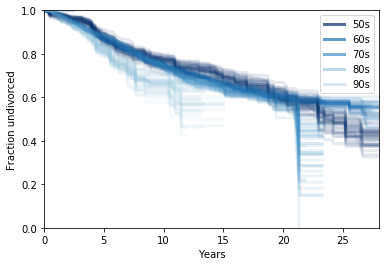

In [19]:
# Solution
ResampleDivorceCurveByDecade([married6, married7])